In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

# Reproducibility
RANDOM_SEED: int = 42
np.random.seed(RANDOM_SEED)

# IEEE-style plotting parameters
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
})

In [6]:
def load_ecg_dataset(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load ECG dataset and split into signals and labels.

    Parameters
    ----------
    path : str
        Path to CSV file.

    Returns
    -------
    X : np.ndarray
        ECG signals of shape (n_samples, 140)
    y : np.ndarray
        Labels of shape (n_samples,)
    """
    df = pd.read_csv(path, header=None)

    assert df.shape[1] == 141, "Expected 141 columns (140 ECG + 1 label)."

    X = df.iloc[:, :-1].values.astype(np.float32)
    y = df.iloc[:, -1].values.astype(np.int64)

    return X, y


# Update path if required
DATA_PATH = "ecg.csv"
X, y = load_ecg_dataset(DATA_PATH)

print("Dataset loaded successfully")
print(f"Total samples      : {X.shape[0]}")
print(f"Signal length      : {X.shape[1]}")
print(f"Normal ECG count   : {np.sum(y == 0)}")
print(f"Abnormal ECG count : {np.sum(y == 1)}")

Dataset loaded successfully
Total samples      : 4998
Signal length      : 140
Normal ECG count   : 2079
Abnormal ECG count : 2919


In [7]:
def zscore_per_record(ecg: np.ndarray) -> np.ndarray:
    mean = ecg.mean(axis=1, keepdims=True)
    std = ecg.std(axis=1, keepdims=True) + 1e-8
    return (ecg - mean) / std


X_norm = zscore_per_record(X)

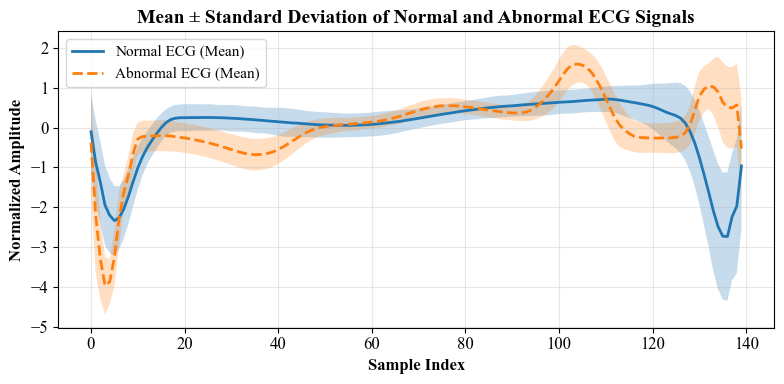

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# IEEE-style rcParams (assumed persistent, included here for completeness)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# Time axis
time_axis = np.arange(X_norm.shape[1])

# Separate classes
X_normal = X_norm[y == 0]
X_abnormal = X_norm[y == 1]

# Compute statistics
mean_normal = np.mean(X_normal, axis=0)
std_normal = np.std(X_normal, axis=0)

mean_abnormal = np.mean(X_abnormal, axis=0)
std_abnormal = np.std(X_abnormal, axis=0)

# Plot
plt.figure(figsize=(8, 4))

plt.plot(time_axis, mean_normal,
         label="Normal ECG (Mean)",
         linewidth=2)

plt.fill_between(time_axis,
                 mean_normal - std_normal,
                 mean_normal + std_normal,
                 alpha=0.25)

plt.plot(time_axis, mean_abnormal,
         label="Abnormal ECG (Mean)",
         linewidth=2,
         linestyle="--")

plt.fill_between(time_axis,
                 mean_abnormal - std_abnormal,
                 mean_abnormal + std_abnormal,
                 alpha=0.25)

plt.xlabel("Sample Index", fontweight="bold")
plt.ylabel("Normalized Amplitude", fontweight="bold")
plt.title("Mean ± Standard Deviation of Normal and Abnormal ECG Signals",
          fontweight="bold")

plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
from typing import List

QRS_WINDOW: int = 32
HALF_WIN: int = QRS_WINDOW // 2


def extract_qrs_segment(signal: np.ndarray) -> np.ndarray:
    """
    Extract QRS-centered window from a single ECG signal.
    """
    center = np.argmax(np.abs(signal))
    start = max(center - HALF_WIN, 0)
    end = start + QRS_WINDOW

    if end > len(signal):
        end = len(signal)
        start = end - QRS_WINDOW

    return signal[start:end]

In [9]:
# ============================================================
# STEP 2C: QRS Template Construction
# ============================================================

X_normal = X_norm[y == 0]

qrs_segments: List[np.ndarray] = [
    extract_qrs_segment(ecg) for ecg in X_normal
]

qrs_segments = np.stack(qrs_segments)

qrs_template = qrs_segments.mean(axis=0)
qrs_std = qrs_segments.std(axis=0)

print("QRS template shape:", qrs_template.shape)

QRS template shape: (32,)


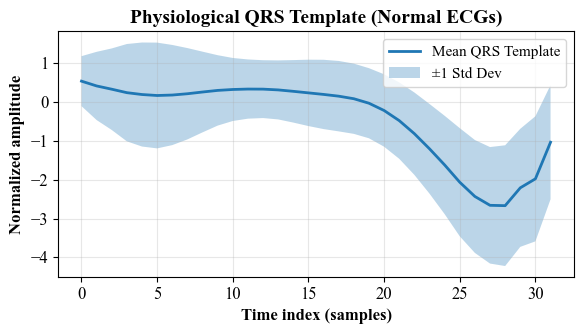

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3.5))

time_axis = np.arange(QRS_WINDOW)

plt.plot(
    time_axis,
    qrs_template,
    label="Mean QRS Template",
    linewidth=2
)

plt.fill_between(
    time_axis,
    qrs_template - qrs_std,
    qrs_template + qrs_std,
    alpha=0.3,
    label="±1 Std Dev"
)

plt.xlabel("Time index (samples)",fontweight='bold')
plt.ylabel("Normalized amplitude",fontweight='bold')
plt.title("Physiological QRS Template (Normal ECGs)",fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
def morphology_loss(
    reconstructed_qrs: np.ndarray,
    template_qrs: np.ndarray
) -> float:
    """
    1 - Pearson correlation between reconstructed QRS and template.
    """
    r = np.corrcoef(reconstructed_qrs, template_qrs)[0, 1]
    return 1.0 - r

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# ============================================================
# FORCE CPU-ONLY (SAFE FOR WINDOWS + PY312)
# ============================================================
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# -----------------------
# Reproducibility
# -----------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.18.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [17]:
class ResidualBlock1D(layers.Layer):
    def __init__(self, out_channels: int, kernel_size: int = 3):
        super().__init__()

        self.conv1 = layers.Conv1D(
            out_channels, kernel_size, padding="same"
        )
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv1D(
            out_channels, kernel_size, padding="same"
        )
        self.bn2 = layers.BatchNormalization()

        self.skip_conv = None

    def build(self, input_shape):
        if input_shape[-1] != self.conv1.filters:
            self.skip_conv = layers.Conv1D(
                self.conv1.filters, kernel_size=1, padding="same"
            )

    def call(self, x, training=False):
        identity = x
        if self.skip_conv is not None:
            identity = self.skip_conv(identity)

        out = tf.nn.relu(self.bn1(self.conv1(x), training=training))
        out = self.bn2(self.conv2(out), training=training)
        out = out + identity
        return tf.nn.relu(out)

In [23]:
class ECGEncoder(tf.keras.Model):
    def __init__(self, latent_dim: int = 32):
        super().__init__()

        self.block1 = ResidualBlock1D(32)
        self.pool1 = tf.keras.layers.MaxPooling1D(2)

        self.block2 = ResidualBlock1D(64)
        self.pool2 = tf.keras.layers.MaxPooling1D(2)

        self.block3 = ResidualBlock1D(128)
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()

        self.fc_mu = tf.keras.layers.Dense(latent_dim)
        self.fc_logvar = tf.keras.layers.Dense(latent_dim)

    def call(self, x, training=None):
        x = self.block1(x, training=training)
        x = self.pool1(x)

        x = self.block2(x, training=training)
        x = self.pool2(x)

        x = self.block3(x, training=training)
        x = self.global_pool(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [24]:
class ECGDecoder(tf.keras.Model):
    def __init__(self, latent_dim: int = 32):
        super().__init__()

        self.fc = tf.keras.layers.Dense(128)
        self.expand = tf.keras.layers.Reshape((1, 128))
        self.upsample = tf.keras.layers.UpSampling1D(size=35)

        self.block1 = ResidualBlock1D(64)
        self.block2 = ResidualBlock1D(32)

        self.out_conv = tf.keras.layers.Conv1D(
            1, kernel_size=3, padding="same"
        )

    def call(self, z, training=None):
        x = self.fc(z)
        x = self.expand(x)
        x = self.upsample(x)

        x = self.block1(x, training=training)
        x = self.block2(x, training=training)

        return self.out_conv(x)

In [32]:
class ECGDecoder(tf.keras.Model):
    def __init__(self, latent_dim: int = 32):
        super().__init__()

        self.fc = tf.keras.layers.Dense(35 * 128)
        self.reshape = tf.keras.layers.Reshape((35, 128))

        self.block1 = ResidualBlock1D(128)
        self.upsample1 = tf.keras.layers.UpSampling1D(size=2)  # 35 → 70

        self.block2 = ResidualBlock1D(64)
        self.upsample2 = tf.keras.layers.UpSampling1D(size=2)  # 70 → 140

        self.block3 = ResidualBlock1D(32)

        self.out_conv = tf.keras.layers.Conv1D(
            1, kernel_size=3, padding="same"
        )

    def call(self, z, training=None):
        x = self.fc(z)
        x = self.reshape(x)

        x = self.block1(x, training=training)
        x = self.upsample1(x)

        x = self.block2(x, training=training)
        x = self.upsample2(x)

        x = self.block3(x, training=training)

        return self.out_conv(x)

In [33]:
class PCVAE(tf.keras.Model):
    def __init__(self, latent_dim: int = 32):
        super().__init__()

        self.encoder = ECGEncoder(latent_dim)
        self.sampler = Sampling()
        self.decoder = ECGDecoder(latent_dim)

    def call(self, x, training=None):
        mu, logvar = self.encoder(x, training=training)
        z = self.sampler((mu, logvar))
        recon = self.decoder(z, training=training)
        return recon, mu, logvar

In [34]:
model = PCVAE(latent_dim=32)

dummy_input = tf.random.normal((4, 140, 1))
recon, mu, logvar = model(dummy_input, training=False)

print("Input shape :", dummy_input.shape)
print("Recon shape :", recon.shape)
print("Mu shape    :", mu.shape)
print("LogVar shape:", logvar.shape)

Input shape : (4, 140, 1)
Recon shape : (4, 140, 1)
Mu shape    : (4, 32)
LogVar shape: (4, 32)


In [35]:
import tensorflow as tf

def reconstruction_loss(x_true, x_recon):
    # Mean squared error over time
    return tf.reduce_mean(tf.reduce_sum(tf.square(x_true - x_recon), axis=[1, 2]))


def kl_divergence(mu, logvar):
    # Standard VAE KL term
    return -0.5 * tf.reduce_mean(
        tf.reduce_sum(1.0 + logvar - tf.square(mu) - tf.exp(logvar), axis=1)
    )

In [36]:
def nt_xent_loss(z1, z2, temperature: float = 0.5):
    """
    NT-Xent loss for contrastive learning.
    z1, z2: (batch, latent_dim)
    """
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)

    logits = tf.matmul(z1, z2, transpose_b=True) / temperature
    batch_size = tf.shape(z1)[0]

    labels = tf.range(batch_size)
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )
    return tf.reduce_mean(loss)

In [37]:
# Assume qrs_template is already computed in NumPy
# Convert once to TensorFlow constant
qrs_template_tf = tf.constant(qrs_template, dtype=tf.float32)

QRS_WINDOW = qrs_template.shape[0]
HALF_WIN = QRS_WINDOW // 2


def extract_qrs_tf(signal):
    """
    signal: (batch, 140, 1)
    returns: (batch, QRS_WINDOW)
    """
    signal_1d = tf.squeeze(signal, axis=-1)
    center = tf.argmax(tf.abs(signal_1d), axis=1)

    def slice_one(sig, c):
        start = tf.maximum(c - HALF_WIN, 0)
        start = tf.minimum(start, 140 - QRS_WINDOW)
        return sig[start:start + QRS_WINDOW]

    qrs = tf.map_fn(
        lambda x: slice_one(x[0], x[1]),
        (signal_1d, center),
        fn_output_signature=tf.float32
    )
    return qrs


def morphology_loss(x_recon):
    """
    1 - Pearson correlation between reconstructed QRS and template
    """
    qrs_recon = extract_qrs_tf(x_recon)

    qrs_recon = qrs_recon - tf.reduce_mean(qrs_recon, axis=1, keepdims=True)
    template = qrs_template_tf - tf.reduce_mean(qrs_template_tf)

    num = tf.reduce_sum(qrs_recon * template, axis=1)
    den = tf.sqrt(
        tf.reduce_sum(tf.square(qrs_recon), axis=1) *
        tf.reduce_sum(tf.square(template))
    ) + 1e-8

    corr = num / den
    return tf.reduce_mean(1.0 - corr)

In [38]:
class PCVAETrainer(PCVAE):
    def __init__(
        self,
        latent_dim: int = 32,
        alpha: float = 1.0,
        beta: float = 1e-3,
        gamma: float = 0.1,
        delta: float = 0.5,
        temperature: float = 0.5,
    ):
        super().__init__(latent_dim)

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.temperature = temperature

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.rec_loss_tracker = tf.keras.metrics.Mean(name="rec_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.con_loss_tracker = tf.keras.metrics.Mean(name="con_loss")
        self.morph_loss_tracker = tf.keras.metrics.Mean(name="morph_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.rec_loss_tracker,
            self.kl_loss_tracker,
            self.con_loss_tracker,
            self.morph_loss_tracker,
        ]

    def train_step(self, data):
        x = data

        with tf.GradientTape() as tape:
            # First stochastic pass
            recon1, mu1, logvar1 = self(x, training=True)
            z1 = mu1 + tf.exp(0.5 * logvar1) * tf.random.normal(tf.shape(mu1))

            # Second stochastic pass
            recon2, mu2, logvar2 = self(x, training=True)
            z2 = mu2 + tf.exp(0.5 * logvar2) * tf.random.normal(tf.shape(mu2))

            rec = reconstruction_loss(x, recon1)
            kl = kl_divergence(mu1, logvar1)
            con = nt_xent_loss(z1, z2, self.temperature)
            morph = morphology_loss(recon1)

            total = (
                self.alpha * rec +
                self.beta * kl +
                self.gamma * con +
                self.delta * morph
            )

        grads = tape.gradient(total, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total)
        self.rec_loss_tracker.update_state(rec)
        self.kl_loss_tracker.update_state(kl)
        self.con_loss_tracker.update_state(con)
        self.morph_loss_tracker.update_state(morph)

        return {
            "loss": self.total_loss_tracker.result(),
            "rec": self.rec_loss_tracker.result(),
            "kl": self.kl_loss_tracker.result(),
            "contrastive": self.con_loss_tracker.result(),
            "morph": self.morph_loss_tracker.result(),
        }

In [39]:
trainer = PCVAETrainer(
    latent_dim=32,
    alpha=1.0,
    beta=1e-3,
    gamma=0.1,
    delta=0.5
)

trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

# X_norm must be shaped (N, 140, 1)
X_tf = X_norm[..., None].astype("float32")

history = trainer.fit(
    X_tf[y == 0],     # train on NORMAL ECGs only
    epochs=5,
    batch_size=32,
    shuffle=True
)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 54s 116ms/step - contrastive: 3.3759 - kl: 34.7663 - loss: 87.4728 - morph: 0.5254 - rec: 86.8378
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - contrastive: 3.2499 - kl: 65.9470 - loss: 24.3294 - morph: 0.3838 - rec: 23.7466
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - contrastive: 3.1130 - kl: 67.8602 - loss: 17.0172 - morph: 0.3107 - rec: 16.4827
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - contrastive: 3.0210 - kl: 70.5881 - loss: 13.5550 - morph: 0.3018 - rec: 13.0314
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - contrastive: 2.9403 - kl: 73.7705 - loss: 11.3607 - morph: 0.3182 - rec: 10.8338


In [43]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/90.1 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/90.1 kB ? eta -:--:--
   --------------------------- ------------ 61.4/90.1 kB 656.4 kB/s eta 0:00:01
   --------------------------- ------------ 61.4/90.1 kB 656.4 kB/s eta 0:00:01
   ------------------------------- -------- 71.7/90.1 kB 357.2 kB/s eta 0:00:01
   ------------------------------- -------- 71.7/90.1 kB 357.2 kB/s eta 0:00:01
   ---------------------------------------- 90.1/90.1 kB 300.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ------- -------------------------------- 10.2/56.9 kB ? eta -:--:--
   --------------------- ------------------ 30.7/56.9 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 56.9/56.9 kB 495.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   --------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.16.0 requires scikit-learn<1.7,>=1.0, but you have scikit-learn 1.8.0 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.8.0 which is incompatible.


In [41]:
pip uninstall umap

Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np

# ------------------------------------------------
# Ensure input shape is (N, 140, 1)
# ------------------------------------------------
X_tf = X_norm[..., None].astype("float32")

# ------------------------------------------------
# Extract latent mean μ from encoder
# ------------------------------------------------
mu_tf, _ = trainer.encoder(X_tf, training=False)
mu_np = mu_tf.numpy()

print("Latent matrix shape:", mu_np.shape)

Latent matrix shape: (4998, 32)


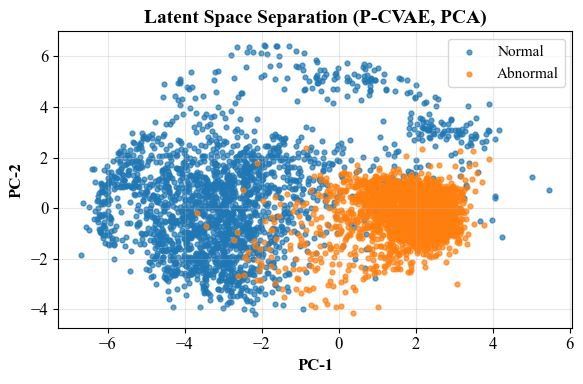

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# IEEE-style rcParams
# -----------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# -----------------------
# NumPy PCA (NO sklearn)
# -----------------------
X_latent = mu_np.copy()

# Center
X_centered = X_latent - np.mean(X_latent, axis=0, keepdims=True)

# Covariance matrix
cov = np.cov(X_centered, rowvar=False)

# Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(cov)

# Sort eigenvectors by descending eigenvalues
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

# Project to 2D
embedding = X_centered @ eigvecs[:, :2]

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(6, 4))

plt.scatter(
    embedding[y == 0, 0],
    embedding[y == 0, 1],
    s=12,
    alpha=0.7,
    label="Normal"
)

plt.scatter(
    embedding[y == 1, 0],
    embedding[y == 1, 1],
    s=12,
    alpha=0.7,
    label="Abnormal"
)

plt.xlabel("PC-1",fontweight='bold')
plt.ylabel("PC-2",fontweight='bold')
plt.title("Latent Space Separation (P-CVAE, PCA)",fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [50]:
import numpy as np

def compute_anomaly_score(trainer, X_tf, y):
    """
    Composite anomaly score = reconstruction error + latent distance
    """
    recon, mu, _ = trainer(X_tf, training=False)
    recon = recon.numpy()
    mu = mu.numpy()

    # Reconstruction error (MSE per sample)
    rec_err = np.mean((X_tf[:, :, 0] - recon[:, :, 0])**2, axis=1)

    # Latent distance to normal centroid
    mu_norm_centroid = mu[y == 0].mean(axis=0)
    latent_dist = np.linalg.norm(mu - mu_norm_centroid, axis=1)

    return rec_err + latent_dist

In [51]:
def train_variant(gamma, delta, epochs=5):
    model = PCVAETrainer(
        latent_dim=32,
        alpha=1.0,
        beta=1e-3,
        gamma=gamma,
        delta=delta
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
    )
    model.fit(
        X_tf[y == 0],
        epochs=epochs,
        batch_size=32,
        shuffle=True,
        verbose=0
    )
    return model

In [52]:
# Full model
model_full = train_variant(gamma=0.1, delta=0.5)

# Without contrastive loss
model_no_con = train_variant(gamma=0.0, delta=0.5)

# Without morphology loss
model_no_morph = train_variant(gamma=0.1, delta=0.0)

In [53]:
def separation_index(scores, y):
    mu_n = scores[y == 0].mean()
    mu_a = scores[y == 1].mean()
    std_n = scores[y == 0].std()
    std_a = scores[y == 1].std()
    return (mu_a - mu_n) / (std_a + std_n + 1e-8)


si_full = separation_index(
    compute_anomaly_score(model_full, X_tf, y), y
)

si_no_con = separation_index(
    compute_anomaly_score(model_no_con, X_tf, y), y
)

si_no_morph = separation_index(
    compute_anomaly_score(model_no_morph, X_tf, y), y
)

print("Separation Index:")
print("Full P-CVAE       :", si_full)
print("w/o Contrastive   :", si_no_con)
print("w/o Morphology    :", si_no_morph)

Separation Index:
Full P-CVAE       : 0.819598164564149
w/o Contrastive   : 0.928686021434931
w/o Morphology    : 0.6393452349480072


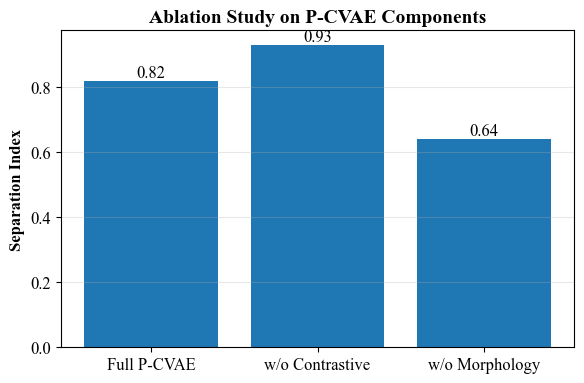

In [57]:
import matplotlib.pyplot as plt

labels = ["Full P-CVAE", "w/o Contrastive", "w/o Morphology"]
values = [si_full, si_no_con, si_no_morph]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)

plt.ylabel("Separation Index",fontweight='bold')
plt.title("Ablation Study on P-CVAE Components",fontsize=14, fontweight='bold')
plt.grid(axis="y", alpha=0.3)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )
plt.tight_layout()
plt.show()

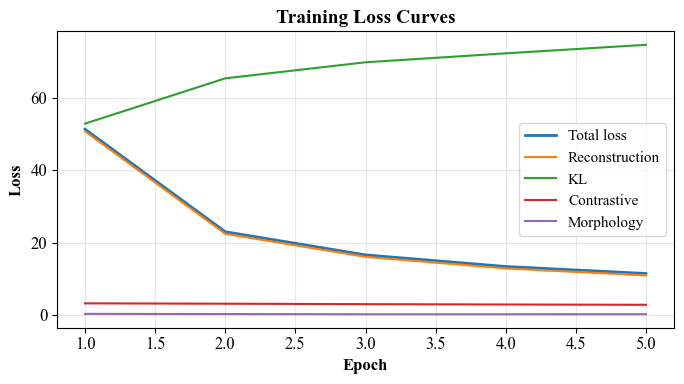

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Try to retrieve history dict safely
history_dict = None
if "history" in globals() and hasattr(history, "history"):
    history_dict = history.history
elif hasattr(trainer, "history") and hasattr(trainer.history, "history"):
    history_dict = trainer.history.history

if history_dict is None:
    print("Warning: no History object found (variable 'history' or trainer.history). "
          "Skipping loss-curve plot.")
else:
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "savefig.dpi": 300
    })

    epochs = np.arange(1, len(next(iter(history_dict.values()))) + 1)
    plt.figure(figsize=(7, 4))

    if "loss" in history_dict:
        plt.plot(epochs, history_dict["loss"], label="Total loss", linewidth=2)
    if "rec" in history_dict:
        plt.plot(epochs, history_dict["rec"], label="Reconstruction", linewidth=1.5)
    if "kl" in history_dict:
        plt.plot(epochs, history_dict["kl"], label="KL", linewidth=1.5)
    if "contrastive" in history_dict:
        plt.plot(epochs, history_dict["contrastive"], label="Contrastive", linewidth=1.5)
    if "morph" in history_dict:
        plt.plot(epochs, history_dict["morph"], label="Morphology", linewidth=1.5)

    plt.xlabel("Epoch",fontweight='bold')
    plt.ylabel("Loss",fontweight='bold')
    plt.title("Training Loss Curves",fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

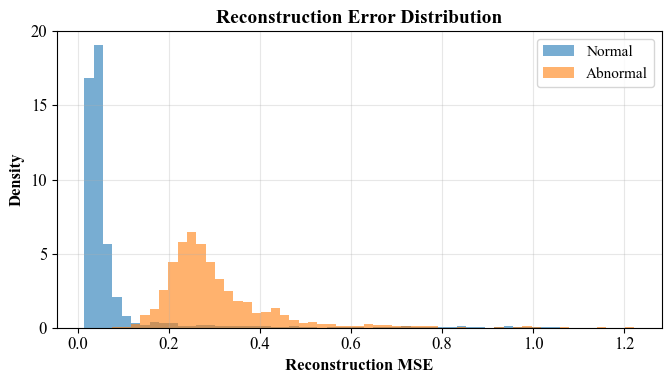

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# compute recon errors if not already computed
try:
    recon_all, mu_all, _ = trainer(X_tf, training=False)
    recon_all = recon_all.numpy()
except Exception as e:
    print("Error computing reconstructions:", e)
    recon_all = None

if recon_all is None:
    print("Skipping reconstruction histogram due to missing reconstructions.")
else:
    rec_err = np.mean((X_tf[:, :, 0] - recon_all[:, :, 0])**2, axis=1)

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "savefig.dpi": 300
    })

    plt.figure(figsize=(7, 4))
    bins = np.linspace(rec_err.min(), rec_err.max(), 60)

    plt.hist(rec_err[y == 0], bins=bins, alpha=0.6, label="Normal", density=True)
    plt.hist(rec_err[y == 1], bins=bins, alpha=0.6, label="Abnormal", density=True)

    plt.xlabel("Reconstruction MSE",fontweight='bold')
    plt.ylabel("Density",fontweight='bold')
    plt.title("Reconstruction Error Distribution",fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

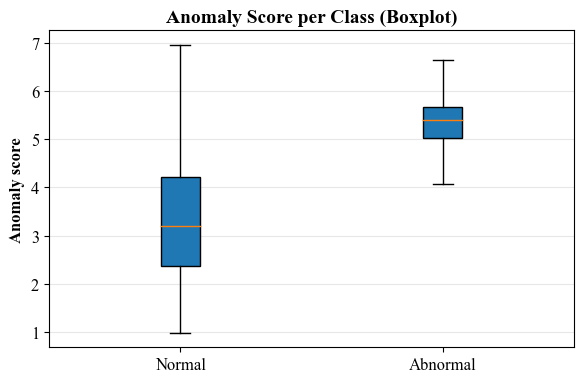

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# compute anomaly score if not present
def compute_anomaly_score_np(recon_arr, mu_arr, X_tf_arr, y_arr):
    rec_err = np.mean((X_tf_arr[:, :, 0] - recon_arr[:, :, 0])**2, axis=1)
    mu_norm_centroid = mu_arr[y_arr == 0].mean(axis=0)
    latent_dist = np.linalg.norm(mu_arr - mu_norm_centroid, axis=1)
    return rec_err + latent_dist

if recon_all is None:
    print("Skipping boxplot: reconstructions missing.")
else:
    mu_all_np = mu_all.numpy() if hasattr(mu_all, "numpy") else mu_all
    anomaly_scores = compute_anomaly_score_np(recon_all, mu_all_np, X_tf, y)

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "savefig.dpi": 300
    })

    labels = ["Normal", "Abnormal"]
    data = [anomaly_scores[y == 0], anomaly_scores[y == 1]]

    plt.figure(figsize=(6, 4))
    plt.boxplot(data, labels=labels, patch_artist=True, showfliers=False)
    plt.ylabel("Anomaly score",fontweight='bold')
    plt.title("Anomaly Score per Class (Boxplot)",fontsize=14, fontweight='bold')
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

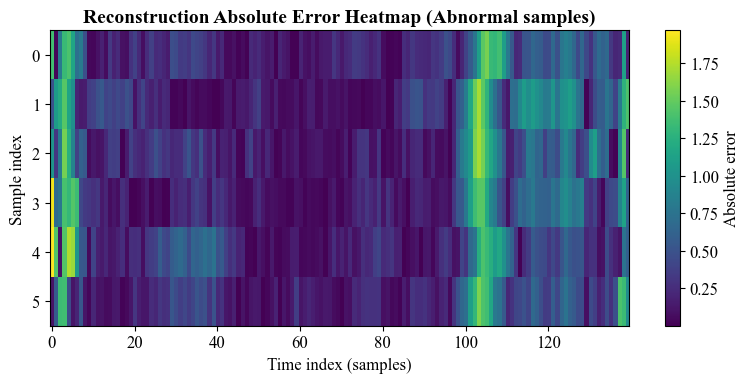

In [94]:
import numpy as np
import matplotlib.pyplot as plt

if recon_all is None:
    print("Skipping error heatmap: reconstructions missing.")
else:
    # choose up to 6 abnormal samples (or fewer if not available)
    idxs = np.where(y == 1)[0]
    if len(idxs) == 0:
        print("No abnormal samples found; skipping heatmap.")
    else:
        sel = idxs[:6]
        errors = np.abs(X_tf[sel, :, 0] - recon_all[sel, :, 0])  # shape (k, 140)

        plt.rcParams.update({
            "font.family": "serif",
            "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
            "font.size": 12,
            "axes.labelsize": 12,
            "axes.titlesize": 14,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
            "legend.fontsize": 11,
            "savefig.dpi": 300
        })

        plt.figure(figsize=(8, 4))
        plt.imshow(errors, aspect="auto", interpolation="nearest")
        plt.colorbar(label="Absolute error")
        plt.xlabel("Time index (samples)")
        plt.ylabel("Sample index")
        plt.title("Reconstruction Absolute Error Heatmap (Abnormal samples)",fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

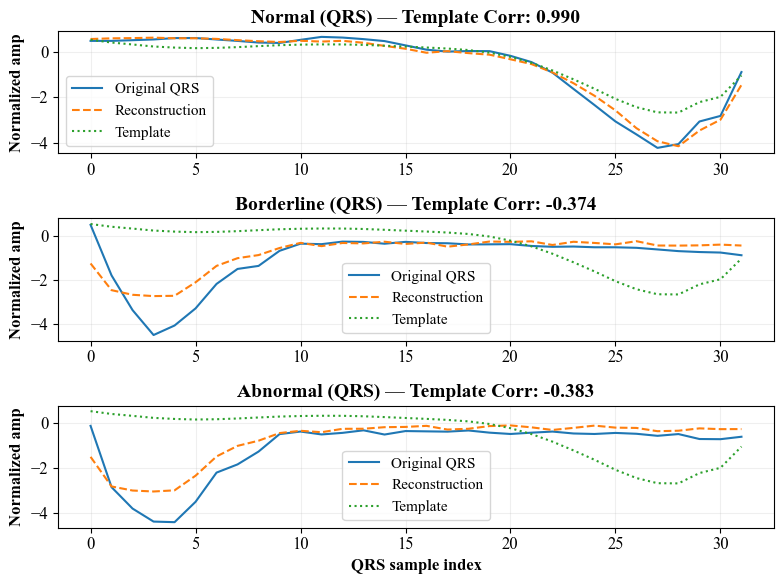

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# helper: extract qrs indices (reuse method from morphology extraction)
def extract_qrs_indices(signal_1d):
    center = np.argmax(np.abs(signal_1d))
    start = max(center - (len(qrs_template)//2), 0)
    start = min(start, 140 - len(qrs_template))
    return start, start + len(qrs_template)

if recon_all is None:
    print("Skipping QRS overlay: reconstructions missing.")
else:
    # pick one normal, one abnormal, and one borderline (closest to centroid)
    normal_idx = np.where(y == 0)[0][0]
    abnormal_idx = np.where(y == 1)[0][0]

    # borderline: sample with anomaly score closest to median of abnormal
    mu_all_np = mu_all.numpy() if hasattr(mu_all, "numpy") else mu_all
    anomaly_scores = compute_anomaly_score_np(recon_all, mu_all_np, X_tf, y)
    if np.any(y == 1):
        abn_scores = anomaly_scores[y == 1]
        median_abn = np.median(abn_scores)
        abn_idxs = np.where(y == 1)[0]
        borderline_idx = abn_idxs[np.argmin(np.abs(anomaly_scores[abn_idxs] - median_abn))]
    else:
        borderline_idx = normal_idx

    examples = [normal_idx, borderline_idx, abnormal_idx]
    titles = ["Normal", "Borderline", "Abnormal"]

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "savefig.dpi": 300
    })

    plt.figure(figsize=(8, 6))
    for i, idx in enumerate(examples):
        sig = X_tf[idx, :, 0]
        recon_sig = recon_all[idx, :, 0]
        start, end = extract_qrs_indices(sig)
        qrs = sig[start:end]
        qrs_recon = recon_sig[start:end]

        plt.subplot(3, 1, i+1)
        plt.plot(np.arange(len(qrs)), qrs, label="Original QRS", linewidth=1.5)
        plt.plot(np.arange(len(qrs)), qrs_recon, linestyle="--", label="Reconstruction")
        plt.plot(np.arange(len(qrs)), qrs_template, linestyle=":", label="Template")
        # compute Pearson R between qrs_recon and template
        r = np.corrcoef(qrs_recon, qrs_template)[0,1]
        plt.title(f"{titles[i]} (QRS) — Template Corr: {r:.3f}",fontsize=14,fontweight='bold')
        plt.legend()
        plt.ylabel("Normalized amp",fontweight='bold')
        plt.grid(True, alpha=0.2)
    plt.xlabel("QRS sample index",fontweight='bold')
    plt.tight_layout()
    plt.show()

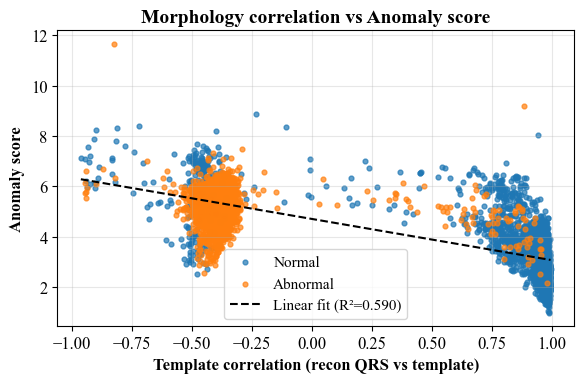

In [96]:
import numpy as np
import matplotlib.pyplot as plt

if recon_all is None:
    print("Skipping correlation scatter: reconstructions missing.")
else:
    # compute per-sample template correlation
    def corr_with_template_per_sample(recon_arr, template):
        k = recon_arr.shape[0]
        out = np.zeros(k, dtype=float)
        half = len(template) // 2
        for i in range(k):
            sig = recon_arr[i,:,0]
            center = np.argmax(np.abs(sig))
            start = max(center - half, 0)
            start = min(start, 140 - len(template))
            qrs = sig[start:start+len(template)]
            qrs = qrs - qrs.mean()
            t = template - template.mean()
            num = np.sum(qrs * t)
            den = np.sqrt(np.sum(qrs**2) * np.sum(t**2)) + 1e-8
            out[i] = num / den
        return out

    template_corrs = corr_with_template_per_sample(recon_all, qrs_template)
    # anomaly scores computed earlier as `anomaly_scores`
    # compute simple linear regression (R^2)
    X = np.vstack([np.ones_like(template_corrs), template_corrs]).T
    coef, residuals, rank, s = np.linalg.lstsq(X, anomaly_scores, rcond=None)
    y_pred = X @ coef
    ss_res = np.sum((anomaly_scores - y_pred)**2)
    ss_tot = np.sum((anomaly_scores - anomaly_scores.mean())**2)
    r2 = 1 - ss_res / (ss_tot + 1e-12)

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "savefig.dpi": 300
    })

    plt.figure(figsize=(6, 4))
    plt.scatter(template_corrs[y==0], anomaly_scores[y==0], label="Normal", s=12, alpha=0.7)
    plt.scatter(template_corrs[y==1], anomaly_scores[y==1], label="Abnormal", s=12, alpha=0.7)
    # regression line
    xs = np.linspace(template_corrs.min(), template_corrs.max(), 100)
    ys = coef[0] + coef[1] * xs
    plt.plot(xs, ys, linestyle='--', label=f"Linear fit (R²={r2:.3f})", linewidth=1.5, color='black')

    plt.xlabel("Template correlation (recon QRS vs template)",fontweight='bold')
    plt.ylabel("Anomaly score",fontweight='bold')
    plt.title("Morphology correlation vs Anomaly score",fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

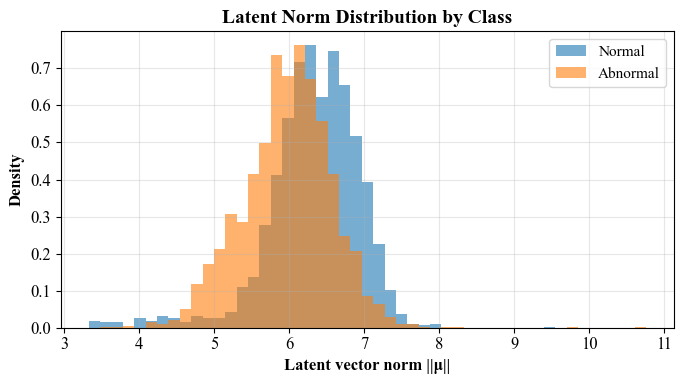

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# compute mu if not present
try:
    mu_tf2, _ = trainer.encoder(X_tf, training=False)
    mu_np = mu_tf2.numpy()
except Exception:
    pass

latent_norm = np.linalg.norm(mu_np, axis=1)

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

plt.figure(figsize=(7, 4))
bins = np.linspace(latent_norm.min(), latent_norm.max(), 50)
plt.hist(latent_norm[y==0], bins=bins, alpha=0.6, label="Normal", density=True)
plt.hist(latent_norm[y==1], bins=bins, alpha=0.6, label="Abnormal", density=True)
plt.xlabel("Latent vector norm ||μ||",fontweight='bold')
plt.ylabel("Density",fontweight='bold')
plt.title("Latent Norm Distribution by Class",fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

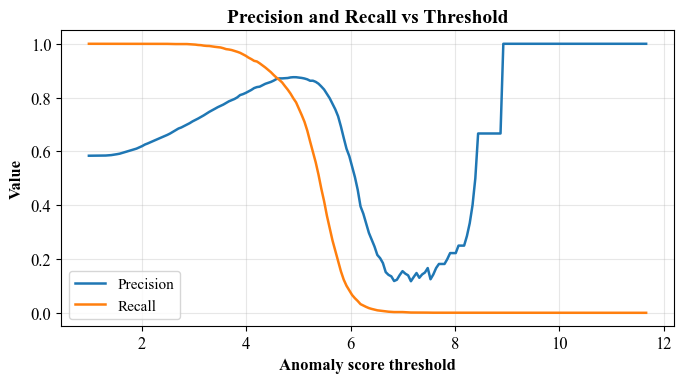

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# use anomaly_scores computed previously
if 'anomaly_scores' not in globals():
    # compute if missing
    try:
        mu_all_np = mu_all.numpy() if hasattr(mu_all, "numpy") else mu_all
        anomaly_scores = compute_anomaly_score_np(recon_all, mu_all_np, X_tf, y)
    except Exception as e:
        print("Cannot compute anomaly_scores:", e)
        anomaly_scores = None

if anomaly_scores is None:
    print("Skipping precision-recall vs threshold plot.")
else:
    thresholds = np.linspace(anomaly_scores.min(), anomaly_scores.max(), 200)
    precisions = []
    recalls = []
    for t in thresholds:
        preds = (anomaly_scores >= t).astype(int)
        tp = np.sum((preds == 1) & (y == 1))
        fp = np.sum((preds == 1) & (y == 0))
        fn = np.sum((preds == 0) & (y == 1))
        prec = tp / (tp + fp + 1e-12)
        rec = tp / (tp + fn + 1e-12)
        precisions.append(prec)
        recalls.append(rec)

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "savefig.dpi": 300
    })

    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, precisions, label="Precision", linewidth=1.8)
    plt.plot(thresholds, recalls, label="Recall", linewidth=1.8)
    plt.xlabel("Anomaly score threshold",fontweight='bold')
    plt.ylabel("Value",fontweight='bold')
    plt.title("Precision and Recall vs Threshold",fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()